In [61]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import QTable
import numpy as np
from reproject import reproject_interp
import os 
from tqdm import tqdm 
from astropy.table import join

plt.style.use('paper.mplstyle')

In [62]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table_wprops = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wprops.fits' %root_dir)
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir)

table = table[table['flag_star_MUSE']!=1]
table_wprops = table_wprops[table_wprops['flag_star_MUSE']!=1]
table_muse = table_muse[table_muse['flag_star']!=1]

if len(table) != len(table_wprops):
    print('Warning: Tables are not the same length!')

In [63]:
def get_files(endswith, root_dir): 

    file_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(endswith):
                if '628e' in file: 
                    continue
                else: 
                    print(os.path.join(root, file))
                    file_list += [os.path.join(root, file)]

    print('TOTAL NUMBER OF FILES:', len(file_list))

    return file_list

files_maps = get_files('_hst_ha_bsic.fits', root_dir)
files_nebs_ = get_files('_nebmask.fits', root_dir)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/hst_contsub/ngc3627_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/hst_contsub/ngc4254_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1512/hst_contsub/ngc1512_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/hst_contsub/ngc1433_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/hst_contsub/ngc5068_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4321/hst_contsub/ngc4321_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1365n/hst_contsub/ngc1365n_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4303/hst_contsub/ngc4303_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1087/hst_contsub/ngc1087_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallpr

In [64]:
def match_files(files1, files2, root_dir, id=0, verbose=True):
    matched_files = []
    for file1 in files1:
        for file2 in files2:
            if file1.split(root_dir)[-1].split('/')[2] == file2.split(root_dir)[-1].split('/')[2]:
                if verbose: 
                    print(file1, file2)
                matched_files.append(file2)
                break

    if len(files1) != len(matched_files):
        print('WARNING: DIFFERENT NUMBER OF FILES')

    return matched_files

files_nebs = match_files(files_maps, files_nebs_, root_dir, 2)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/hst_contsub/ngc3627_hst_ha_bsic.fits /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/muse/NGC3627_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/hst_contsub/ngc4254_hst_ha_bsic.fits /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/muse/NGC4254_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1512/hst_contsub/ngc1512_hst_ha_bsic.fits /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1512/muse/NGC1512_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/hst_contsub/ngc1433_hst_ha_bsic.fits /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/muse/NGC1433_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/hst_contsub/ngc5068_hst_ha_bsic.fits /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/muse/NGC506

In [80]:
# Regrid all MUSE NebCat data to HST pixels

regrid_musecat = False
if regrid_musecat: 

    nfiles = len(files_maps)
    for i in tqdm(range(nfiles)): 

        if 'ngc628c' not in files_maps[i]: 
            continue

        file_maps, file_nebs = files_maps[i], files_nebs[i]

        # Loading files...
        hstha_hdu = fits.open(file_maps)[0]
        muscat_hdu = fits.open(file_nebs)[0]

        # Update arrays
        muscat_hdu.data = np.array(muscat_hdu.data, dtype=float)
        muscat_hdu.data[muscat_hdu.data==-1] = np.nan

        # Interpolate masks
        muscat_data_re, _ = reproject_interp(muscat_hdu, hstha_hdu.header, order='nearest-neighbor')
        muscat_data_re[np.isnan(hstha_hdu.data)] = np.nan

        muscat_hdu_re = fits.PrimaryHDU(muscat_data_re, hstha_hdu.header)
        muscat_hdu_re.writeto(file_maps.replace('_hst_ha_bsic.fits', '_muse_nebmask_regrid.fits'), overwrite=True)
        muscat_hdu.writeto(file_maps.replace('_hst_ha_bsic.fits', '_muse_nebmask.fits'), overwrite=True)

        print(file_maps.replace('_hst_ha.fits', '_muse_nebmask_regrid.fits'))

files_nebs_r = get_files('_muse_nebmask_regrid.fits', root_dir)

100%|██████████| 18/18 [00:01<00:00, 17.03it/s]

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_hst_ha_bsic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/hst_contsub/ngc3627_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/hst_contsub/ngc4254_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1512/hst_contsub/ngc1512_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/hst_contsub/ngc1433_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/hst_contsub/ngc5068_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4321/hst_contsub/ngc4321_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1365n/hst_contsub/ngc1365n_muse_nebmask_regrid.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4303/hst_contsub/ngc4

masked_array(data=[False, False, False, False,  True, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False,  True, False, False, False,  True,
                   False, False, False, False, False, False, False, False,
                   False,  True,  True, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False,  True, False, False, False, False,  True, False,
                    True, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                    True,

In [102]:
data_table = []
nfiles = len(files_maps)
table_muse_masked = []

for i in range(nfiles): 

    file_maps = files_maps[i]
    file_nebs = files_nebs[i]
    file_nebs_r = files_nebs_r[i]

    gal_name = file_nebs_r.split(root_dir)[-1].split('/')[2]
    gal_name = gal_name.upper()
    gal_name = gal_name.replace('1365N', '1365')
    gal_name = gal_name.replace('2835S', '2835')
    gal_name = gal_name.replace('628C', '0628')

    mask_gal_hst = table['gal_name'] == gal_name
    mask_gal_muse = table_muse['gal_name'] == gal_name

    muscat_hdu = fits.open(file_nebs)[0]
    muscat_hdu_r = fits.open(file_nebs_r)[0]

    # ALL regions from MUSE map within HST coverage - inc stars
    map_ids = np.unique(muscat_hdu_r.data)
    map_ids = map_ids[~np.isnan(map_ids)]

    # ALL regions from MUSE map with MUSE coverage - inc stars
    map_ids_noregrid = np.unique(muscat_hdu.data)
    map_ids_noregrid = map_ids_noregrid[~np.isnan(map_ids_noregrid)]
    map_ids_noregrid = map_ids_noregrid[map_ids_noregrid!=-1]

    # ALL regions in MUSE table within MUSE coverage
    tab_ids = table_muse[mask_gal_muse]['region_ID'] 

    # Create mask where tab_ids are in map_ids
    mask = np.zeros(len(tab_ids), dtype=bool)
    for i, tab_id in enumerate(tab_ids): 
        mask[i] = tab_id in map_ids

    # Get masked tables 
    table_muse_masked_gal = table_muse[mask_gal_muse][mask]     # MUSE table within HST coverage per galaxy
    table_muse_masked += [table_muse_masked_gal]                # MUSE table within HST coverage all
    table_hst_masked = table[mask_gal_hst]
    table_wprops_masked = table_wprops[mask_gal_hst]

    nreg_muse_map = len(map_ids_noregrid)                      # total number of regions in MUSE map - inc stars
    nreg_muse = len(table_muse[mask_gal_muse])                 # total number of regions in MUSE table
    nreg_muse_masked = len(table_muse[mask_gal_muse][mask])    # total number of regions in MUSE within HST coverage
    nreg_hst = len(table_hst_masked)                           # total number of regions in HST (within MUSE coverage)
    nreg_hst_complex_0 = sum(table_hst_masked['complexity_score'] <= 1)
    nreg_hst_complex_1 = sum((table_hst_masked['complexity_score'] > 1) & (table_hst_masked['complexity_score'] <= 5))
    nreg_hst_complex_2 = sum(table_hst_masked['complexity_score'] > 5)
    nreg_hst_hii = len(table_hst_masked[table_hst_masked['HII_class_v3_MUSE']==1]) # total number of HII regions in HST (within MUSE coverage)
    nreg_hst_ne = len(table_wprops_masked[(table_wprops_masked['HII_class_v3_MUSE']==1) & ~np.isnan(table_wprops_masked['ne'])]) # total number of HII regions with ne in HST (within MUSE coverage)

    mask_center_hst = table_hst_masked['Environment_MUSE'] != 1
    mask_center_mus = table_muse_masked_gal['Environment'] != 1

    lum_tot_muse = np.nansum(table_muse_masked_gal['Lum_HA6562_CORR'])           # Total MUSE luminosity of all regions in MUSE within HST coverage
    lum_tot_hst_muse = np.nansum(table_hst_masked['HA6562_LUMINOSITY_MUSE'])     # Total MUSE luminosity of all regions in HST within MUSE coverage
    lum_tot_hst = np.nansum(table_hst_masked['HA6562_LUMINOSITY_HST'])           # Total HST luminosity of all regions in HST within MUSE coverage

    lum_tot_muse_cent = np.nansum(table_muse_masked_gal['Lum_HA6562_CORR'][mask_center_mus])           # Total MUSE luminosity of all regions in MUSE within HST coverage
    lum_tot_hst_muse_cent = np.nansum(table_hst_masked['HA6562_LUMINOSITY_MUSE'][mask_center_hst])     # Total MUSE luminosity of all regions in HST within MUSE coverage
    lum_tot_hst_cent = np.nansum(table_hst_masked['HA6562_LUMINOSITY_HST'][mask_center_hst])           # Total HST luminosity of all regions in HST within MUSE coverage

    gal_name = gal_name.replace('0628', '628')
    gal_name = gal_name.replace('NGC', 'NGC~')
    gal_name = gal_name.replace('IC', 'IC~')

    gal_data = [gal_name]
    gal_data += [nreg_muse, 
                nreg_muse_masked, 
                nreg_hst,
                nreg_hst_complex_0,
                nreg_hst_complex_1,
                nreg_hst_complex_2,
                nreg_hst_hii,
                nreg_hst_ne,
                (nreg_hst/nreg_muse_masked)*100, 
                (lum_tot_hst/lum_tot_muse).value*100,
                (lum_tot_hst_cent/lum_tot_muse_cent).value*100
                ]

    data_table.append(gal_data)

# MUSE table within HST coverage - all galaxies
table_muse_masked = QTable(np.concatenate(table_muse_masked))
table_muse_masked.sort(['gal_name', 'region_ID'])

In [100]:
len_table_hst = len(table)
len_table_muse = len(table_muse)
len_table_hst_wprops = len(table_wprops)
len_table_muse_masked = len(table_muse_masked)
len_table_hst_hii = len(table[table['HII_class_v3_MUSE']==1])
len_table_hst_hii_ne = len(table_wprops[(table_wprops['HII_class_v3_MUSE']==1) & ~np.isnan(table_wprops['ne'])])

print('Number of regions in MUSE table (all 19 galaxies):', len_table_muse)
print('Number of regions in MUSE table within HST coverage:', len_table_muse_masked)

print('Number of regions in HST table:', len_table_hst)
print('Number of regions in HST table with properties:', len_table_hst_wprops)

print('Number of HII regions in HST table:', len_table_hst_hii)
print('Number of HII regions in HST table with ne:', len_table_hst_hii_ne)

Number of regions in MUSE table (all 19 galaxies): 31399
Number of regions in MUSE table within HST coverage: 1
Number of regions in HST table: 8654
Number of regions in HST table with properties: 8654
Number of HII regions in HST table: 7971
Number of HII regions in HST table with ne: 2555


In [98]:
# Create a new QTable 
new_columns = ['gal_name', 'nreg_muse', 'nreg_muse_masked', 'nreg_hst', 
               'nreg_hst_complex_0', 'nreg_hst_complex_1', 'nreg_hst_complex_2',
               'nreg_hst_hii', 'nreg_hst_hii_ne', 'frac_nreg', 'frac_lum', 'frac_lum_cent']
new_table = QTable(rows=data_table, names=new_columns)

new_table.sort('gal_name')

nreg_tot_muse = np.sum(new_table['nreg_muse'])
nreg_tot_musemasked = np.sum(new_table['nreg_muse_masked'])
nreg_tot_hst = np.sum(new_table['nreg_hst'])
nreg_tot_hst_complex_0 = np.sum(new_table['nreg_hst_complex_0'])
nreg_tot_hst_complex_1 = np.sum(new_table['nreg_hst_complex_1'])
nreg_tot_hst_complex_2 = np.sum(new_table['nreg_hst_complex_2'])
nreg_tot_hst_hii = np.sum(new_table['nreg_hst_hii'])
nreg_tot_hst_ne = np.sum(new_table['nreg_hst_hii_ne'])

lum_tot_muse = np.nansum(table_muse_masked['Lum_HA6562_CORR'])    # Total MUSE luminosity of all regions in MUSE within HST coverage
lum_tot_hst_muse = np.nansum(table['HA6562_LUMINOSITY_MUSE'])     # Total MUSE luminosity of all regions in HST within MUSE coverage
lum_tot_hst = np.nansum(table['HA6562_LUMINOSITY_HST'])           # Total HST luminosity of all regions in HST within MUSE coverage

mask_center_hst = table['Environment_MUSE'] != 1
mask_center_mus = table_muse_masked['Environment'] != 1

lum_tot_muse_cent = np.nansum(table_muse_masked['Lum_HA6562_CORR'][mask_center_mus])           # Total MUSE luminosity of all regions in MUSE within HST coverage
lum_tot_hst_muse_cent = np.nansum(table['HA6562_LUMINOSITY_MUSE'][mask_center_hst])     # Total MUSE luminosity of all regions in HST within MUSE coverage
lum_tot_hst_cent = np.nansum(table['HA6562_LUMINOSITY_HST'][mask_center_hst])          # Total HST luminosity of all regions in HST within MUSE coverage

# sum columns in new_table and append at end with row "total"
new_table.add_row(['Total', 
                    nreg_tot_muse, 
                    nreg_tot_musemasked, 
                    nreg_tot_hst, 
                    nreg_tot_hst_complex_0,
                    nreg_tot_hst_complex_1,
                    nreg_tot_hst_complex_2,
                    nreg_tot_hst_hii,
                    nreg_tot_hst_ne,
                    (nreg_tot_hst/nreg_tot_musemasked)*100, 
                    (lum_tot_hst/lum_tot_muse).value*100, 
                    (lum_tot_hst_cent/lum_tot_muse_cent).value*100])

formats = {'frac_nreg': '%0.1f', 'frac_lum': '%0.1f', 'frac_lum_cent': '%0.1f'}
new_table.write('./tabs/galmap_compprops.tex', formats=formats, overwrite=True)
new_table

gal_name,nreg_muse,nreg_muse_masked,nreg_hst,nreg_hst_complex_0,nreg_hst_complex_1,nreg_hst_complex_2,nreg_hst_hii,nreg_hst_hii_ne,frac_nreg,frac_lum,frac_lum_cent
str8,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64
IC~5332,813,772,134,47,68,19,120,12,17.357512953367877,54.45060972608405,54.72660974716519
NGC~1087,1010,999,406,80,179,147,403,122,40.64064064064064,79.18457856109559,79.18457856109559
NGC~1300,1472,1455,580,88,314,178,531,94,39.86254295532646,98.73319778462934,87.7142608197184
NGC~1365,1449,899,237,48,92,97,171,77,26.362625139043384,97.93989110111863,74.65568641468123
NGC~1385,1029,1029,377,57,159,161,371,200,36.63751214771623,78.6667632656909,78.6667632656909
NGC~1433,1732,1019,134,26,70,38,108,34,13.150147203140333,103.50177438948019,48.89826067570723
NGC~1512,626,490,144,28,73,43,137,33,29.38775510204082,73.80139788104533,54.2696373150828
NGC~1566,2396,2092,727,96,288,343,651,255,34.75143403441683,82.31350278579896,84.5916138247811
NGC~1672,1574,1548,582,90,257,235,530,216,37.5968992248062,101.16120046864529,87.06366022160262


In [89]:
# # Load in error map stats 
# table_err = QTable.read('./tabs/galmap_props.fits')

# for gal_name in table_err['gal_name']: 
#     gal_name_new = gal_name.replace('0628', '628')
#     # gal_name_new = gal_name_new.replace('NGC', 'NGC~')
#     # gal_name_new = gal_name_new.replace('IC', 'IC~')
#     table_err['gal_name'][table_err['gal_name'] == gal_name] = gal_name_new

# table_err = table_err['gal_name', 'filter', 'median_arcsec2']

# new_table_comb = join(table_err, new_table, keys='gal_name')

# new_table_comb.add_row(['Total', '-' , np.nan, nreg_tot_muse, nreg_tot_musemasked, nreg_tot_hst, 
#                    (nreg_tot_hst/nreg_tot_musemasked)*100, 
#                    (lum_tot_hst/lum_tot_muse).value*100, 
#                    (lum_tot_hst_cent/lum_tot_muse_cent).value*100])

# formats = {'frac_nreg': '%0.1f', 'frac_lum': '%0.1f', 'frac_lum_cent': '%0.1f', 'median_arcsec2': '%0.1f'}
# new_table_comb.write('./tabs/galmap_props.tex', formats=formats, overwrite=True)
# new_table_comb

In [90]:
run_detections = False
if run_detections: 
    
    detections_all = []
    gal_names = np.unique(table_muse_masked['gal_name'])
    for gal_name in tqdm(gal_names): 

        table_muse_masked_gal = table_muse_masked[table_muse_masked['gal_name'] == gal_name]
        table_hst_gal = table[table['gal_name'] == gal_name]

        region_IDs = table_muse_masked_gal['region_ID']
        detections = np.ones(len(region_IDs), dtype=bool)

        for i, region_ID in enumerate(region_IDs):

            if region_ID not in table_hst_gal['region_ID']:
                detection = False
            else : 
                detection = True

            detections[i] = detection

        detections_all += [detections]

    detections_all = np.concatenate(detections_all)
    table_muse_masked.add_column(detections_all, name='detection')

100%|██████████| 18/18 [00:00<00:00, 20.72it/s]


In [91]:
def get_completeness(xdata, ydata, nbins=20, number=True):

    binmin = np.nanmin(xdata)
    binmax = np.nanmax(xdata)
    nbins = 20

    # Llims = np.logspace(np.log10(Lmin), np.log10(Lmax), nbins)
    binlims = np.linspace(binmin, binmax, nbins)
    bincent = binlims[:-1]+((binlims[1:] - binlims[:-1])/2)

    comp_bins = np.zeros(nbins-1) # number of detections in each bin
    compfrac_bins = np.zeros(nbins-1) # fraction of detections in each bin (complete fraction)
    ntot_bins = np.zeros(nbins-1) # total number of regions in each bin

    for i in range(len(bincent)): 
        mask = (xdata>binlims[i]) & (xdata<binlims[i+1])
        comp_bins[i] = np.sum(ydata[mask]*1)

        compfrac_bins[i] = comp_bins[i]/np.sum(mask)
        ntot_bins[i] = np.sum(mask) 

    return bincent, ntot_bins, compfrac_bins

Lcent, L_num, Lcomp_num = get_completeness(np.log10(table_muse_masked['Lum_HA6562_CORR']), detections_all)
Scent, S_num, Scomp_num = get_completeness(np.log10(table_muse_masked['HA6562_FLUX']/(table_muse_masked['region_area'])*0.2**2), detections_all, nbins=15)

# area = table_muse_masked['region_area']*table_muse_masked['pc_per_pixel']**2
# Scent, Scomp_num = get_completeness(np.log10(table_muse_masked['Lum_HA6562_CORR']/area), detections_all, nbins=15)

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_81530/2347120077.py:19: RuntimeWarning: invalid value encountered in scalar divide
  compfrac_bins[i] = comp_bins[i]/np.sum(mask)


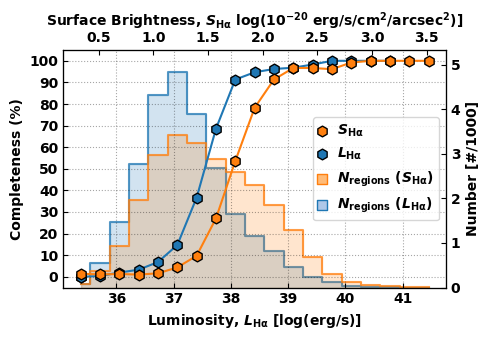

In [92]:
data_x1 = Lcent
data_y1 = Lcomp_num*100
data_z1 = L_num/1000
data_x2 = Scent
data_y2 = Scomp_num*100
data_z2 = S_num/1000

colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

fig = plt.figure(figsize=(5, 3.5)) 
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()

ax1.plot(data_x1, data_y1)
ax2.plot(data_x2, data_y2, color='C1')

ax1.scatter(data_x1[0], data_y1[0], s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1, label=r'$S_\mathrm{H\alpha}$')
ax1.scatter(data_x1, data_y1, s=60, ec='black', fc='C0', zorder=10, marker='h', lw=1, label=r'$L_\mathrm{H\alpha}$')
ax2.scatter(data_x2, data_y2, s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1)

ax3.plot(data_x1, data_z1, color='C0', alpha=0.75, ds='steps-mid', zorder=0)
ax3.fill_between(data_x1, data_z1, alpha=0.2, step='mid', color='C0', zorder=0)

ax3.plot(data_x1, data_z2, color='C1', alpha=0.75, ds='steps-mid', zorder=0)
ax3.fill_between(data_x1, data_z2, alpha=0.2, step='mid', color='C1', zorder=0)

ax1.scatter(np.nan, np.nan, s=50, marker='s', ec=colors1[1], fc=colors2[1], label=r'$N_\mathrm{regions}$ ($S_\mathrm{H\alpha}$)')
ax1.scatter(np.nan, np.nan, s=50, marker='s', ec=colors1[0], fc=colors2[0], label=r'$N_\mathrm{regions}$ ($L_\mathrm{H\alpha}$)')

ax1.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel(r'Luminosity, $L_\mathrm{H\alpha}$ [log(erg/s)]')
ax1.set_ylabel('Completeness (%)')
ax2.set_xlabel(r'Surface Brightness, $S_\mathrm{H\alpha}$ log(10$^{-20}$ erg/s/cm$^2$/arcsec$^2$)]')
ax3.set_ylabel('Number [#/1000]')

ax3.set_ylim(0, max(data_z1)*1.1)

ax1.legend(loc='center right', handlelength=0.5)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax1.set_yticks(np.arange(0, 110, 10))

ax1.set_zorder(1)
ax2.set_zorder(1)
# ax3.set_zorder(1)

ax1.patch.set_visible(False)
ax2.patch.set_visible(False)

fig.savefig('./figs/scatter_completeness.pdf', dpi=200, bbox_inches='tight')

In [93]:
from scipy.interpolate import interp1d
interp_func1 = interp1d(data_y1, data_x1)
interp_func2 = interp1d(data_y2, data_x2)

L50 = interp_func1(50)
S50 = interp_func2(50)

print('L50: %0.1f' %L50)
print('S50: %0.1f' %S50)

L50: 37.5
S50: 1.7
